# Fit a transit of an oblate planet

Here we'll attempt to recover the parameters describing planetary oblateness from a realistic-ish simulated light curve. We'll focus on Kepler-167 e, a cold Jupiter-like planet that will be observed by JWST NIRSpec in Fall 2024

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import export as jax_export
import matplotlib.pyplot as plt
import corner
import numpy as np
from squishyplanet import OblateSystem

import astropy.units as u
import numpy as np
from tynt import Filter
from gadfly import StellarOscillatorKernel, Hyperparameters, GaussianProcess

from scipy.optimize import minimize
from nautilus import Prior, Sampler


np.random.seed(13)

First we'll create the "ideal" transit model of the planet. For this, we'll use parameters reported in [Chachan et al. 2020](https://ui.adsabs.harvard.edu/abs/2022ApJ...926...62C/abstract), then assume the planet is as oblate as and has the same obliquity of Saturn, and a randomly-chosen precession angle.

The JWST observations will have a cadence of ~1.6s, a white light precision of ~600 ppm, and a baseline of ~60 hours. Since that's an enormous amount of data, we'll bin the data to a 5-minute cadence, but will be sure to add the finite exposure time correction to model the resulting transit blurring.

In [2]:
t_exp = 5 * u.min
times = jnp.arange(-30, 30, t_exp.to(u.hour).value) * u.hour.to(u.day)

injected_state = {
    "t_peri": -1071.23205 / 4 + 0.1,
    "times": times,
    "exposure_time": t_exp.to(u.day).value,
    "oversample": 5,  # 5x more samples under-the-hood, then binned back down
    "oversample_correction_order": 2,
    "a": ((1.883 * u.au) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled),
    "period": 1071.23205,
    "r": ((0.9064 * u.R_jup) / (0.749 * u.R_sun)).to(u.dimensionless_unscaled),
    "i": 89.9720 * jnp.pi / 180,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "f1": 0.1,
    "obliq": 26.7 * jnp.pi / 180,  # Saturn obliquity
    "prec": 1.0,
    "tidally_locked": False,
}

injected_planet = OblateSystem(**injected_state)

spherical_planet_state = injected_state.copy()
spherical_planet_state["r"] = injected_planet.state["projected_effective_r"]
spherical_planet_state["f1"] = 0.0
spherical_planet = OblateSystem(**spherical_planet_state)

injected_transit = injected_planet.lightcurve()
spherical_transit = spherical_planet.lightcurve()

Let's inspect what we just created:

Projected flattening: 0.08500084360457456


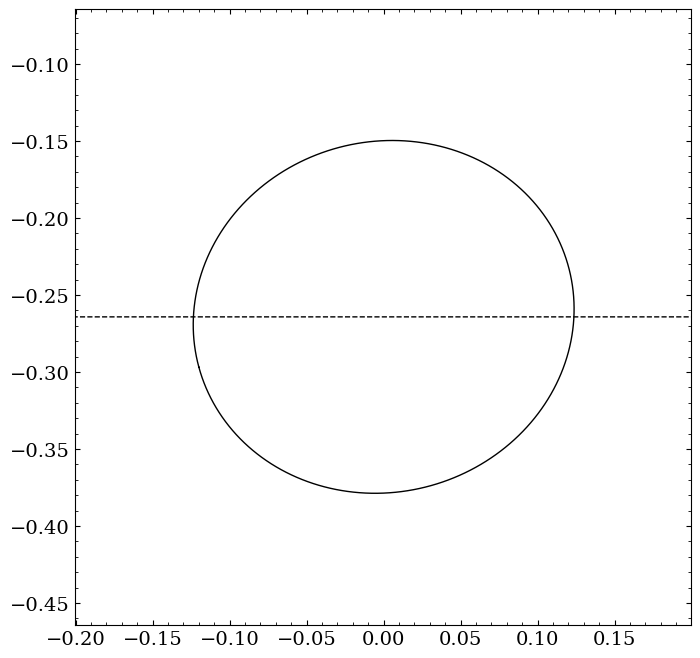

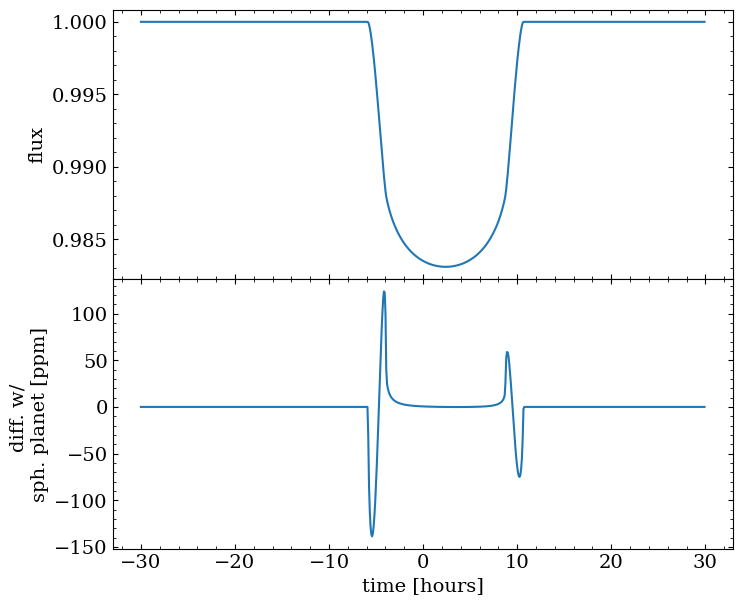

In [3]:
print(f"Projected flattening: {injected_planet.state['projected_f']}")

injected_planet.illustrate(star_fill=False)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 7))
ax[0].plot(times * u.day.to(u.hour), injected_transit)
ax[0].set(ylabel="flux")
ax[1].plot(times * u.day.to(u.hour), (injected_transit - spherical_transit) * 1e6)
ax[1].set(ylabel="diff. w/ \nsph. planet [ppm]", xlabel="time [hours]")
plt.subplots_adjust(hspace=0)

So, we're looking for an effect that's ~100 ppm.

The projected flattening value, f, is less than the true injected f value: that's because we've given the planet some obliquity, which leaves us with a more circular projected ellipse when we only flatten along the $z$ axis with $f_1$ (if the obliquity was a full 90 degrees, we'd see a perfect circle). See [Berardo and de Wit 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...935..178B/abstract) for more details.


Note that the smearing from binning is nearly comparable with the signal during egress, and really should be included. We can see that by comparing the smeared transit to one without the correction:

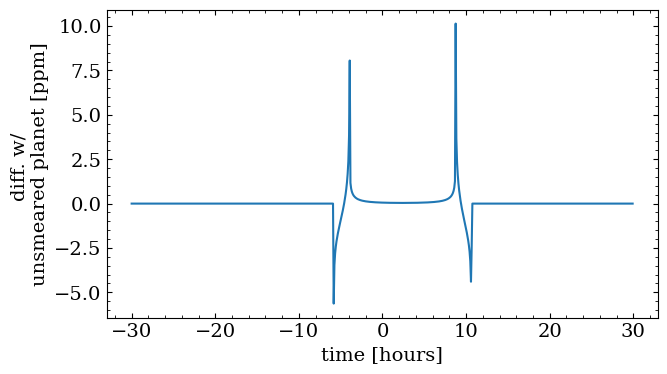

In [4]:
unsmeared_planet_state = injected_state.copy()
unsmeared_planet_state["oversample"] = 1
unsmeared_planet = OblateSystem(**unsmeared_planet_state)
unsmeared_transit = unsmeared_planet.lightcurve()

fig, ax = plt.subplots()
ax.plot(
    times * u.day.to(u.hour),
    (injected_transit - unsmeared_transit) * 1e6,
    label="unsmeared",
)
ax.set(ylabel="diff. w/ \nunsmeared planet [ppm]", xlabel="time [hours]")

Larger `oversample` values don't seem to change the results much, so we'll stick with 5 to avoid extra overhead.

Now we need to add noise to this injected model. We'll include both shot noise from the Poisson statistics of photon counting, and correlated stellar noise using Brett Morris'
[gadfly](https://gadfly-astro.readthedocs.io/en/latest/) package. Again, all parameters are pulled from [Chachan et al. 2020](https://ui.adsabs.harvard.edu/abs/2022ApJ...926...62C/abstract).

Since ``gadfly`` doesn't have support for NIRSpec Prism white light, we'll approximate its bandpass as a step function between 0.7 and 5 microns (more info on NIRSpec bandpasses [here](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters)).

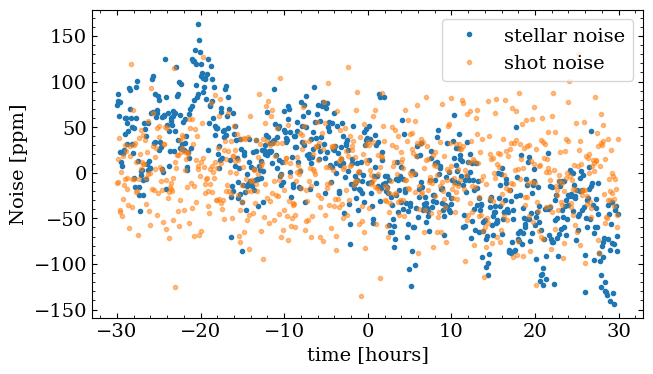

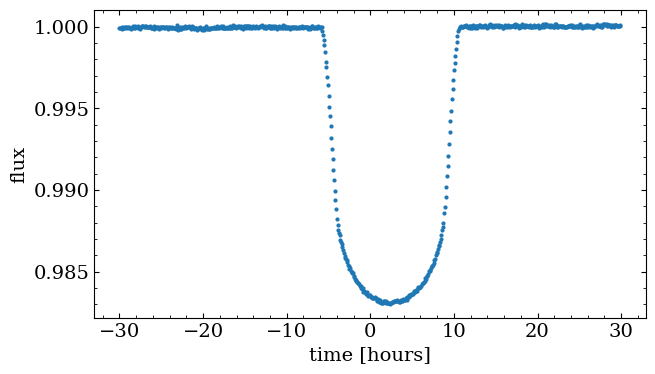

In [5]:
filt = Filter(
    wavelength=jnp.linspace(0.7, 5, 100) * u.micron, transmittance=jnp.ones(100)
)

hp = Hyperparameters.for_star(
    mass=0.777 * u.M_sun,
    radius=0.749 * u.R_sun,
    temperature=4884 * u.K,
    luminosity=10 ** (-0.539) * u.L_sun,
    name="Kepler-167",
    bandpass=filt,
)

np.random.seed(15)
gp = GaussianProcess(kernel=StellarOscillatorKernel(hp, texp=5 * u.min))
gp.compute(times * u.day)  # initialize the gp
stellar_noise = gp.sample()

# rough estimate of expected shot noise: 600 ppm / 1.6 s integration, 5 groups/integration
#
# scale that to the longer exposure time:
shot_noise_amplitude = (600 * 1e-6) / jnp.sqrt(
    ((t_exp) / (1.6 * u.s)).to(u.dimensionless_unscaled)
)
shot_noise = (
    jax.random.normal(jax.random.PRNGKey(0), times.shape) * shot_noise_amplitude * 1e6
)

# the "injected transit" model gives us the fraction of light blocked by the planet,
# so we multiply that by the underlying stellar brightness, then add the shot noise
noised_data = injected_transit * (1 - stellar_noise * 1e-6) + shot_noise * 1e-6

fig, ax = plt.subplots()
ax.plot(
    times * u.day.to(u.hour),
    stellar_noise,
    marker="o",
    ls="none",
    label="stellar noise",
    markersize=3,
)
ax.plot(
    times * u.day.to(u.hour),
    shot_noise,
    marker="o",
    ls="none",
    label="shot noise",
    markersize=3,
    alpha=0.5,
)
ax.set(ylabel="Noise [ppm]", xlabel="time [hours]")
ax.legend()

fig, ax = plt.subplots()
ax.plot(times * u.day.to(u.hour), noised_data, marker="o", markersize=2, ls="none")
ax.set(ylabel="flux", xlabel="time [hours]")

Note that the stellar noise has some structure: we're going to purposefully not try to model that and see if the model can either see through it, or if it'll be tricked into modeling variability as oblateness.

Now we can construct our likelihood and prior functions:

initial loglike: 4121.311258703886


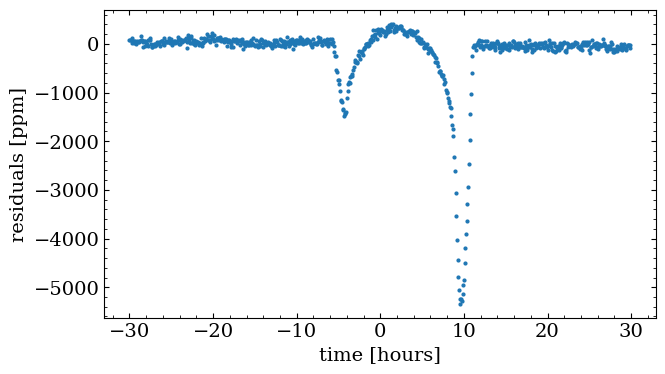

In [6]:
init_state = {
    "times": times,
    "data": noised_data,
    "uncertainties": jnp.ones_like(noised_data) * shot_noise_amplitude,
    "exposure_time": t_exp.to(u.day).value,
    "oversample": 5,  # 5x more samples under-the-hood, then binned back down
    "oversample_correction_order": 2,
    "period": 1071.23205,
    "t_peri": -1071.23205 / 4 + 0.11,
    "tidally_locked": False,
    "parameterize_with_projected_ellipse": True,
    "a": 540.0,
    "i": 90 * jnp.pi / 180,
    "ld_u_coeffs": jnp.array([0.3, 0.2]),
    "projected_effective_r": 0.12,
    "projected_f": 0.0,
    "projected_theta": 0.0,
    "log_jitter": jnp.log(1e-5),
}

planet = OblateSystem(**init_state)


print(f"initial loglike: {planet.loglike()}")

init_lc = planet.lightcurve()
fig, ax = plt.subplots()
ax.errorbar(
    times * u.day.to(u.hour),
    (init_lc - noised_data) * 1e6,
    yerr=shot_noise_amplitude,
    marker="o",
    markersize=2,
    ls="none",
)
ax.set(ylabel="residuals [ppm]", xlabel="time [hours]")

That's obviously not a great fit, but it's just our starting point. Though the above cell takes a few seconds to run, thanks to the jit-compilation, each subsequent likelihood evaluation will be faster than the initial one:

In [7]:
%timeit planet.loglike().block_until_ready()

28.5 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


To get an initial estimate of the best fit, we can use scipy's minimize routines:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -5780.383287059844
        x: [-2.677e+02  5.406e+02  2.705e-01  3.991e-01  3.265e-01
             1.192e-01  9.704e-02  6.945e-03 -1.612e+01]
      nit: 69
      jac: [ 4.366e-02 -9.095e-04  3.092e-03  6.748e-02 -8.731e-03
             2.906e+00  2.801e-02 -1.277e+00  3.382e+02]
     nfev: 920
     njev: 92
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

Optimized parameters:
a: 540.5841000250298
i: 1.5702958804948755
ld_u_coeffs: [0.41254247 0.21922184]
log_jitter: -16.11809565095832
projected_effective_r: 0.11918751352337575
projected_f: 0.09703820634179411
projected_theta: 0.006944729146197154
t_peri: -267.70818832709614


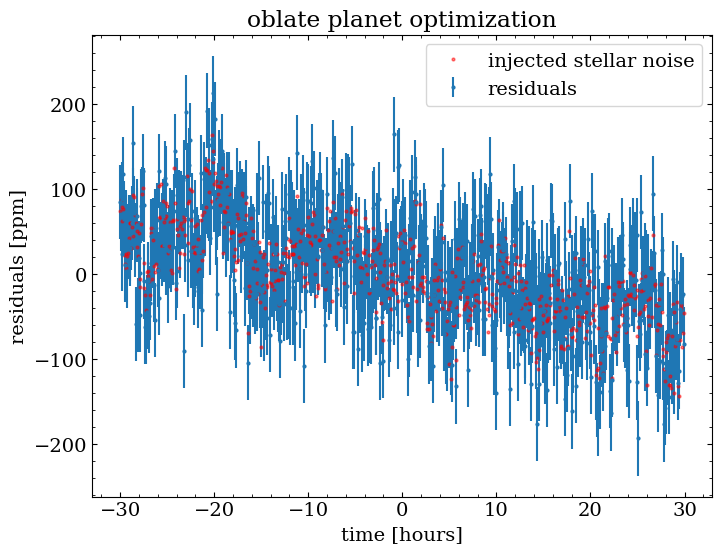

In [8]:
@jax.jit
def translate_to_dict(x):
    t_peri = x[0]
    a = x[1]
    impact_param = x[2]
    i = jnp.arccos(impact_param / a)
    q1 = x[3]  # using the Kipping 2013 uninformative quadratic limb darkening setup
    q2 = x[4]
    u1 = 2 * jnp.sqrt(q1) * q2
    u2 = jnp.sqrt(q1) * (1 - 2 * q2)
    projected_effective_r = x[5]
    projected_f = x[6]
    projected_theta = x[7]
    log_jitter = x[8]

    param_dict = {
        "t_peri": t_peri,
        "a": a,
        "i": i,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": projected_effective_r,
        "projected_f": projected_f,
        "projected_theta": projected_theta,
        "log_jitter": log_jitter,
    }
    return param_dict


def minimizer_fn(x):
    param_dict = translate_to_dict(x)
    return -planet.loglike(param_dict)


init_guess = jnp.array(
    [
        init_state["t_peri"],
        init_state["a"],
        init_state["a"] * jnp.cos(init_state["i"]) + 0.05,
        init_state["ld_u_coeffs"][0] ** 2,
        init_state["ld_u_coeffs"][0] * init_state["ld_u_coeffs"][1] / 2,
        init_state["projected_effective_r"],
        init_state["projected_f"],
        init_state["projected_theta"],
        init_state["log_jitter"],
    ]
)

res = minimize(
    minimizer_fn,
    init_guess,
    bounds=[
        (-1071.23205 / 4 - 0.15, -1071.23205 / 4 + 0.15),
        (530.0, 550.0),
        (0.0, 1.0),
        (0.0, 1.0),
        (0.0, 1.0),
        (0.10, 0.13),
        (0.0, 0.3),
        (0.0, jnp.pi),
        (jnp.log(1e-7), jnp.log(1e-4)),
    ],
)

oblate_resids = planet.lightcurve(translate_to_dict(res.x)) - noised_data

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    times * u.day.to(u.hour),
    oblate_resids * 1e6,
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    label="residuals",
)
ax.plot(
    times * u.day.to(u.hour),
    stellar_noise,
    marker="o",
    markersize=2,
    ls="none",
    color="r",
    alpha=0.5,
    label="injected stellar noise",
)
ax.set(
    ylabel="residuals [ppm]", xlabel="time [hours]", title="oblate planet optimization"
)
ax.legend()

print(res)
print("\nOptimized parameters:")
for key in translate_to_dict(res.x):
    print(f"{key}: {translate_to_dict(res.x)[key]}")

That's much better! There's still some structure to the residuals, but that's dominated by the injected correlated noise we added to mimic the stellar activity. I've plotted that injection in red as a reminder.

To get a sense of how important oblateness is in the fit, let's do the same optimization while fixing the oblateness to zero:

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -5778.742986883001
        x: [-2.677e+02  5.410e+02  2.537e-01  4.657e-01  2.881e-01
             1.186e-01 -1.612e+01]
      nit: 46
      jac: [ 6.777e+00  2.688e-01 -1.443e+00 -9.421e-01 -7.030e-01
            -5.602e+00  3.366e+02]
     nfev: 632
     njev: 79
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

Optimized parameters:
a: 540.9588450083895
i: 1.570327436307757
ld_u_coeffs: [0.39319589 0.28920579]
log_jitter: -16.11809565095832
projected_effective_r: 0.11862177845195918
projected_f: 0.0
projected_theta: 0.0
t_peri: -267.7081874739671


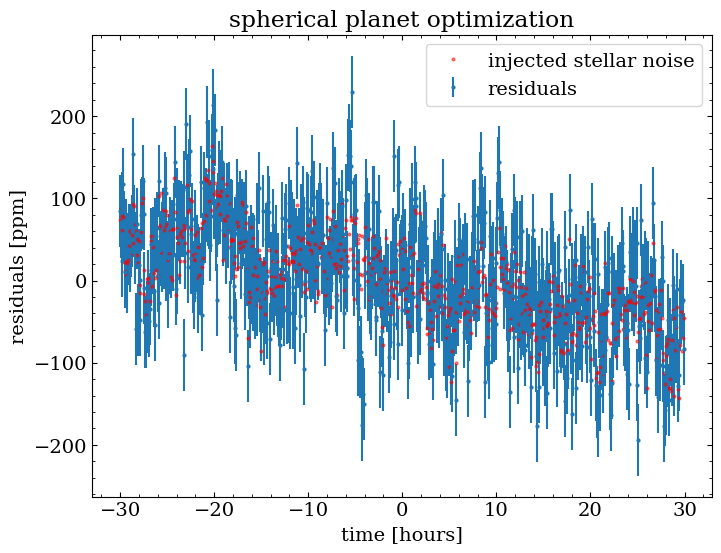

In [9]:
@jax.jit
def translate_to_dict(x):
    t_peri = x[0]
    a = x[1]
    impact_param = x[2]
    i = jnp.arccos(impact_param / a)
    q1 = x[3]  # using the Kipping 2013 uninformative quadratic limb darkening setup
    q2 = x[4]
    u1 = 2 * jnp.sqrt(q1) * q2
    u2 = jnp.sqrt(q1) * (1 - 2 * q2)
    projected_effective_r = x[5]
    # projected_f = x[6]
    # projected_theta = x[7]
    log_jitter = x[6]

    param_dict = {
        "t_peri": t_peri,
        "a": a,
        "i": i,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": projected_effective_r,
        "projected_f": 0.0,
        "projected_theta": 0.0,
        "log_jitter": log_jitter,
    }
    return param_dict


def minimizer_fn(x):
    param_dict = translate_to_dict(x)
    return -planet.loglike(param_dict)


init_guess = jnp.array(
    [
        init_state["t_peri"],
        init_state["a"],
        init_state["a"] * jnp.cos(init_state["i"]) + 0.05,
        init_state["ld_u_coeffs"][0] ** 2,
        init_state["ld_u_coeffs"][0] * init_state["ld_u_coeffs"][1] / 2,
        init_state["projected_effective_r"],
        # init_state["projected_f"],
        # init_state["projected_theta"],
        init_state["log_jitter"],
    ]
)

res = minimize(
    minimizer_fn,
    init_guess,
    bounds=[
        (-1071.23205 / 4 - 0.15, -1071.23205 / 4 + 0.15),
        (530.0, 550.0),
        (0.0, 1.0),
        (0.0, 1.0),
        (0.0, 1.0),
        (0.10, 0.13),
        # (0.0, 0.3),
        # (0.0, jnp.pi),
        (jnp.log(1e-7), jnp.log(1e-4)),
    ],
)

sphere_resids = planet.lightcurve(translate_to_dict(res.x)) - noised_data

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    times * u.day.to(u.hour),
    sphere_resids * 1e6,
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    label="residuals",
)
ax.plot(
    times * u.day.to(u.hour),
    stellar_noise,
    marker="o",
    markersize=2,
    ls="none",
    color="r",
    alpha=0.5,
    label="injected stellar noise",
)
ax.set(
    ylabel="residuals [ppm]",
    xlabel="time [hours]",
    title="spherical planet optimization",
)
ax.legend()

print(res)
print("\nOptimized parameters:")
for key in translate_to_dict(res.x):
    print(f"{key}: {translate_to_dict(res.x)[key]}")

Although we've mandated that the planet is perfectly spherical, the fit is still pretty good. We can see that the oblate model produced a slightly better log likelihood (5780.38) than the spherical model (5778.74), but that's a pretty tiny difference. We can also see that they differ most, unsurprisingly, at ingress and egress:

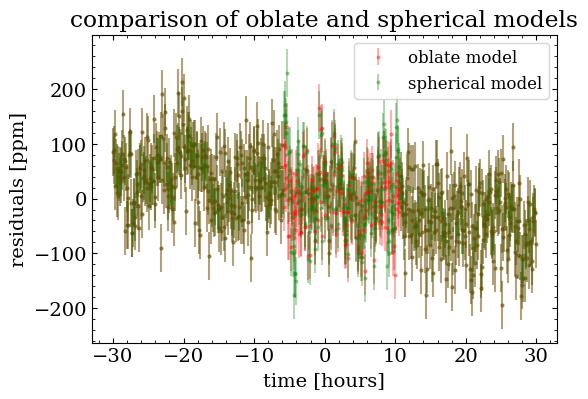

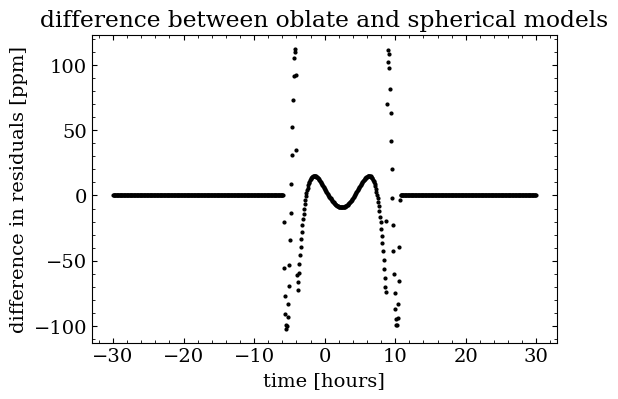

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(
    times * u.day.to(u.hour),
    oblate_resids * 1e6,
    color="r",
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    label="oblate model",
    alpha=0.3,
)
ax.errorbar(
    times * u.day.to(u.hour),
    sphere_resids * 1e6,
    color="g",
    yerr=shot_noise_amplitude * 1e6,
    marker="o",
    markersize=2,
    ls="none",
    label="spherical model",
    alpha=0.3,
)
ax.set(
    ylabel="residuals [ppm]",
    xlabel="time [hours]",
    title="comparison of oblate and spherical models",
)
ax.legend(prop={"size": 12})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    times * u.day.to(u.hour),
    (oblate_resids - sphere_resids) * 1e6,
    color="k",
    marker="o",
    markersize=2,
    ls="none",
)
ax.set(
    ylabel="difference in residuals [ppm]",
    xlabel="time [hours]",
    title="difference between oblate and spherical models",
)

At this point, we could use model selection tools like the Bayesian Information Criterion to determine if the oblate model is favored over the spherical one, but instead, let's go ahead and estimate the Bayesian evidence of each model to compute the Bayes factor.

For that, we'll use the [nautilus](https://nautilus-sampler.readthedocs.io/en/latest/index.html) library's nested sampling routines. ``nautilus``, which is described in full in [Lange 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.525.3181L/abstract), uses a neural net to help select new live points, which can dramatically speed up sampling. If we were doing a real analysis project, it'd be important to run convergence checks on the final results, but here we're just going to use conservative settings and hope for the best. Each of the following fits takes ~2 hours my laptop and no parallelization.

In [11]:
prior = Prior()
prior.add_parameter("t_peri", dist=(-1071.23205 / 4 - 0.15, -1071.23205 / 4 + 0.15))
prior.add_parameter("a", dist=(530.0, 550.0))
prior.add_parameter("b", dist=(0.0, 1.0))
prior.add_parameter("q1", dist=(0.0, 1.0))
prior.add_parameter("q2", dist=(0.0, 1.0))
prior.add_parameter("projected_effective_r", dist=(0.10, 0.13))
prior.add_parameter("projected_f", dist=(0.0, 0.3))
prior.add_parameter("projected_theta", dist=(0.0, jnp.pi))
prior.add_parameter("log_jitter", dist=(jnp.log(1e-7), jnp.log(1e-4)))


@jax.jit
def loglike(x):
    inc = jnp.arccos(x["b"] / x["a"])
    u1 = 2 * jnp.sqrt(x["q1"]) * x["q2"]
    u2 = jnp.sqrt(x["q1"]) * (1 - 2 * x["q2"])

    param_dict = {
        "t_peri": x["t_peri"],
        "a": x["a"],
        "i": inc,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": x["projected_effective_r"],
        "projected_f": x["projected_f"],
        "projected_theta": x["projected_theta"],
        "log_jitter": x["log_jitter"],
    }
    return planet.loglike(param_dict)


sampler1 = Sampler(
    prior,
    loglike,
    n_live=2000,
    seed=0,
    enlarge_per_dim=1.2,
    filepath="nautilus_oblate_checkpoint.hdf5",
    resume=True,
)
sampler1.run(
    f_live=0.001,
    n_eff=50_000,
    n_like_max=np.inf,
    discard_exploration=True,
    timeout=np.inf,
    verbose=True,
)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 52     | 1        | 4        | 180000   | N/A    | 50007 | +5750.30 


True

And now we can do the same for the spherical model:

In [12]:
prior = Prior()
prior.add_parameter("t_peri", dist=(-1071.23205 / 4 - 0.15, -1071.23205 / 4 + 0.15))
prior.add_parameter("a", dist=(530.0, 550.0))
prior.add_parameter("b", dist=(0.0, 1.0))
prior.add_parameter("q1", dist=(0.0, 1.0))
prior.add_parameter("q2", dist=(0.0, 1.0))
prior.add_parameter("projected_effective_r", dist=(0.10, 0.13))
# prior.add_parameter("projected_f", dist=(0.0, 0.3))
# prior.add_parameter("projected_theta", dist=(0.0, jnp.pi))
prior.add_parameter("log_jitter", dist=(jnp.log(1e-7), jnp.log(1e-4)))


@jax.jit
def loglike(x):
    inc = jnp.arccos(x["b"] / x["a"])
    u1 = 2 * jnp.sqrt(x["q1"]) * x["q2"]
    u2 = jnp.sqrt(x["q1"]) * (1 - 2 * x["q2"])

    param_dict = {
        "t_peri": x["t_peri"],
        "a": x["a"],
        "i": inc,
        "ld_u_coeffs": jnp.array([u1, u2]),
        "projected_effective_r": x["projected_effective_r"],
        "projected_f": 0.0,
        "projected_theta": 0.0,
        "log_jitter": x["log_jitter"],
    }
    return planet.loglike(param_dict)


sampler2 = Sampler(
    prior,
    loglike,
    n_live=2000,
    seed=1,
    enlarge_per_dim=1.2,
    filepath="nautilus_sphere_checkpoint.hdf5",
    resume=True,
)
sampler2.run(
    f_live=0.001,
    n_eff=50_000,
    n_like_max=np.inf,
    discard_exploration=True,
    timeout=np.inf,
    verbose=True,
)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 52     | 1        | 4        | 171900   | N/A    | 50030 | +5750.95 


True

In [13]:
print(
    f"the oblate model is preffered over the spherical model by a Bayes factor of: {jnp.exp(sampler1.log_z - sampler2.log_z)}"
)

the oblate model is preffered over the spherical model by a Bayes factor of: 0.5212817249008213


So, it looks like the spherical model is actually slightly preferred in this case. That's not too surprising, given that the oblateness signal is pretty small, that we added in some aggressive stellar noise then intentionally fit a mis-specified model, and that played fast and loose with large uniform priors. But, let's take a look at the posteriors anyway to see what constraints we can place on the oblateness:

In [27]:
o_points, o_log_w, o_log_l = sampler1.posterior()
_s_points, _s_log_w, _s_log_l = sampler2.posterior()

s_points = np.zeros((len(_s_points), o_points.shape[1]))
s_points[:, :-2] = _s_points
s_points[:, -1] = _s_points[:, -1]
s_points[:, -3] *= 0.0

# q1 = (u1+u2)**2
# q2 = u1/(2*(u1+u2))
truth = [
    injected_state["t_peri"],
    injected_state["a"].value,
    (injected_state["a"] * jnp.cos(injected_state["i"])).value,
    (injected_state["ld_u_coeffs"][0] + injected_state["ld_u_coeffs"][1]) ** 2,
    injected_state["ld_u_coeffs"][0]
    / (2 * (injected_state["ld_u_coeffs"][0] + injected_state["ld_u_coeffs"][1])),
    injected_planet.state["projected_effective_r"][0],
    injected_planet.state["projected_f"],
    injected_planet.state["projected_theta"][0],
    None,
]

import warnings

warnings.filterwarnings("ignore")

f = corner.corner(
    s_points,
    weights=np.exp(_s_log_w),
    bins=20,
    labels=[
        "t_peri",
        "a",
        "b",
        "q1",
        "q2",
        "projected_effective_r",
        "projected_f",
        "projected_theta",
        "log_jitter",
    ],
    color="#1285ff",
    plot_datapoints=False,
    range=np.repeat(0.999, 9),
)


corner.corner(
    o_points,
    fig=f,
    weights=np.exp(o_log_w),
    bins=20,
    labels=[
        "t_peri",
        "a",
        "b",
        "q1",
        "q2",
        "projected_effective_r",
        "projected_f",
        "projected_theta",
        "log_jitter",
    ],
    color="#c10029",
    plot_datapoints=False,
    range=np.repeat(0.999, 9),
    truths=truth,
)

plt.savefig("corner_plot.png")
plt.close()

![test](corner_plot.png)

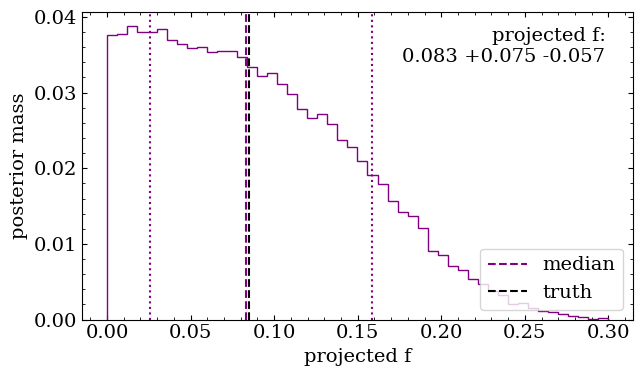

In [15]:
fig, ax = plt.subplots()
ax.hist(
    o_points[:, -3],
    bins=50,
    histtype="step",
    color="purple",
    weights=np.exp(o_log_w),
)
med = np.percentile(o_points[:, -3], 50)
low = np.percentile(o_points[:, -3], 16)
high = np.percentile(o_points[:, -3], 84)
ax.axvline(med, color="purple", ls="--", label="median")
ax.axvline(low, color="purple", ls=":")
ax.axvline(high, color="purple", ls=":")
ax.axvline(injected_planet.state["projected_f"], color="k", ls="--", label="truth")
ax.annotate(
    f"projected f:\n{med:.3f} +{high-med:.3f} -{med-low:.3f}",
    (0.95, 0.95),
    xycoords="axes fraction",
    ha="right",
    va="top",
)
ax.legend(loc="lower right")
ax.set(xlabel="projected f", ylabel="posterior mass")

Even with the noise, we can confidently rule out some extreme oblateness values, and end up recovering the injected value nearly exactly, if you go with the median of the posterior as your final answer.

Hopefully this gives a sense of how you might go about using `squishyplanet`. We used `nautlius` for our inference here, but we just as easily could have used other nested sampling frameworks like `dynesty` or `ultranest`, or even MCMC frameworks like `emcee`. We also could have used the `squishyplanet`-generated lightcurve as the mean for a more complicated systematics model, for example if we wanted to include a GP to model the stellar noise, or some kind of polynomial regression against engineering telemetry to model observatory systematics. `squishyplanet` is designed to leave the inference choices to the user, and just provides the tools to do the transit modeling and likelihood evaluation.